In [41]:
import os
from natsort import natsorted
import pydicom
from pydicom import dcmread
import matplotlib.pyplot as plt

In [4]:
base = 'data/train/'

In [63]:
for pacient in os.listdir(base):
    print(pacient)
    pacient_im_names = os.listdir(base+pacient)
    pacient_im_names = natsorted(pacient_im_names)
    slices = [pydicom.dcmread(base+pacient+'/'+file) for file in pacient_im_names]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    break

ID00170637202238079193844


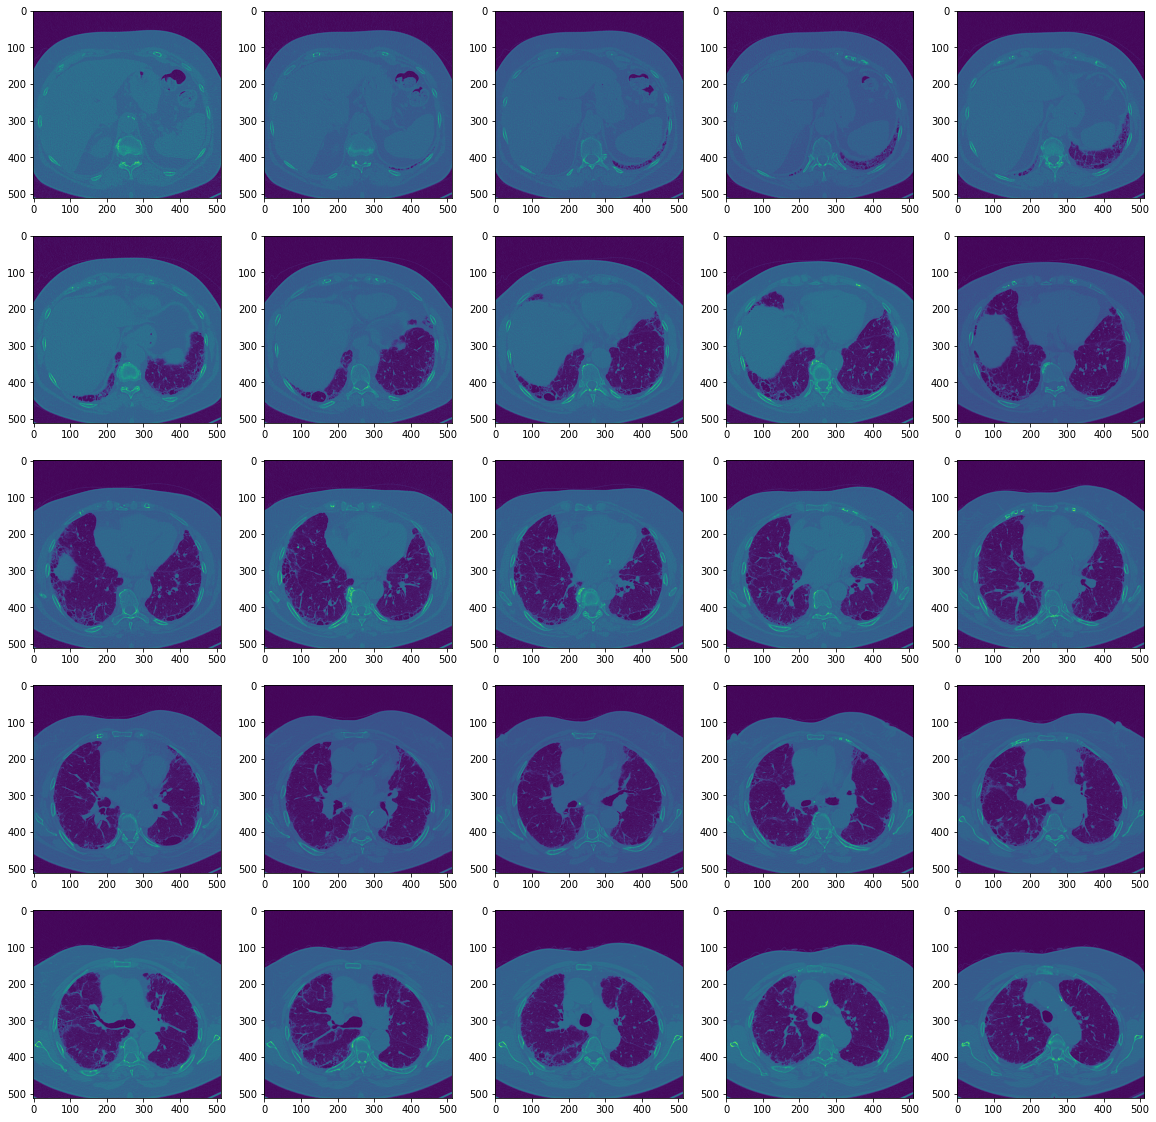

In [64]:
j = 1
l = len(slices)
plt.figure(figsize=(20,20))
for i in range(l):
    if i%int(l/25) == 0 and j<26:
        plt.subplot(5,5,j)
        plt.imshow(slices[i].pixel_array)
        j+=1
plt.show()